In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import distance_matrix
import plotly.graph_objs as go
import plotly.io as pio

# Ensure Plotly will open the plot in the browser
pio.renderers.default = 'browser'

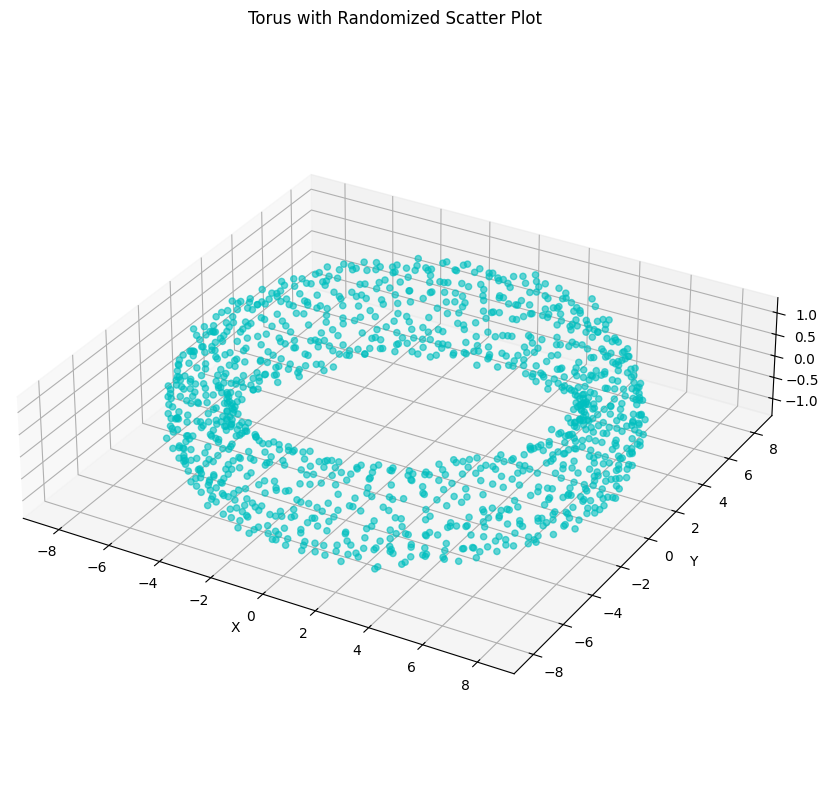

In [2]:
# Generate a random set of points that look like a torus

# Parameters for the torus
R = 7  # Major radius (distance from center of the torus to center of the tube)
r = 1  # Minor radius (radius of the tube)
m = 80 # Number of points along u (how many points along the longitudinal axis of the torus)
n = 15  # Number of points along v (how many points along the meridional axis of the torus)

# Amount of randomness (standard deviation of noise)
randomness = 0.1  # Adjust this value to control how scattered the points are
np.random.seed(42)

# Generate a grid of parameters u and v
u = np.linspace(0, 2 * np.pi, m)
v = np.linspace(0, 2 * np.pi, n)
u, v = np.meshgrid(u, v)

# Parametric equations for the torus
x = (R + r * np.cos(v)) * np.cos(u)
y = (R + r * np.cos(v)) * np.sin(u)
z = r * np.sin(v)

# Add randomness to each coordinate (Gaussian noise)
x = x + np.random.normal(0, randomness, x.shape)
y = y + np.random.normal(0, randomness, y.shape)
z = z + np.random.normal(0, randomness, z.shape)

# Create the point cloud as a list of 3-tuples (x, y, z)
point_cloud = list(zip(x.flatten(), y.flatten(), z.flatten()))

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Flatten arrays for scatter plotting
ax.scatter(x.flatten(), y.flatten(), z.flatten(), c='c', marker='o', alpha=0.6)

# Set axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Torus with Randomized Scatter Plot')

# Ensure equal aspect ratio for all axes
ax.set_box_aspect([4, 4, 1])

plt.show()

In [3]:
class CechAndRipsComplex:
    def __init__(self, point_cloud, max_dimension=None, distance_metric='euclidean'):
        """
        Initialize the CechAndRipsComplex object with a point cloud and optional parameters for max dimension
        and distance metric.
        
        Args:
            point_cloud (list of tuples): A list of tuples representing the points in the point cloud.
            max_dimension (int, optional): Maximum simplex dimension to compute. If not provided, 
                                           it defaults to len(point_cloud[0]) - 1.
            distance_metric (str): The distance metric to use ('euclidean' by default).
        """
        self.point_cloud = point_cloud  # Store the point cloud data
        self.distance_metric = distance_metric  # Store the chosen distance metric
        self.distance_matrix = self._compute_distance_matrix()  # Compute the pairwise distance matrix
        self.cech_complex = None  # Placeholder for the computed Čech complex
        self.rips_complex = None  # Placeholder for the computed Rips complex
        
        # If max_dimension is not provided, set it to point_dim - 1, otherwise, use the provided value
        if max_dimension is None:
            self.max_dimension = len(point_cloud[0]) - 1  # Set default max dimension (point_dim - 1)
        else:
            self.max_dimension = max_dimension  # Use provided max dimension

    def _compute_distance_matrix(self):
        """
        Compute the distance matrix for the point cloud using the chosen distance metric.
        
        Returns:
            A numpy array representing the pairwise distances between points.
        """
        points_array = np.array(self.point_cloud)  # Convert point cloud to numpy array for computation
        return distance_matrix(points_array, points_array)  # Compute pairwise distances

    def compute_cech_complex(self, radius):
        """
        Compute the Čech complex up to the specified max dimension for a given radius.
        
        Args:
            radius (float): The radius used to compute the Čech complex. Simplices are added 
                            if all pairwise distances are <= 2 * radius.
        
        Returns:
            A list of simplices representing the Čech complex.
        """
        n = len(self.point_cloud)  # Number of points in the point cloud
        simplices = []  # List to store the simplices
        
        # Add 0-simplices (vertices)
        simplices.extend([(i,) for i in range(n)])  # Every point is a 0-simplex (vertex)
        
        # Add 1-simplices (edges) based on pairwise distances
        for i in range(n):
            for j in range(i + 1, n):
                if self.distance_matrix[i, j] <= 2 * radius:  # Edge is added if distance between points is <= 2 * radius
                    simplices.append((i, j))
        
        # Add higher-order simplices (up to max_dimension)
        for k in range(3, self.max_dimension + 2):  # Start from 3 (triangles) since edges are already computed
            for simplex in itertools.combinations(range(n), k):
                # Add simplex if all pairwise distances between vertices of the simplex are <= 2 * radius
                if all(self.distance_matrix[i, j] <= 2 * radius for i, j in itertools.combinations(simplex, 2)):
                    simplices.append(simplex)
        
        self.cech_complex = simplices  # Store the computed Čech complex
        return simplices  # Return the list of simplices

    def compute_rips_complex(self, radius):
        """
        Compute the Rips complex up to the specified max dimension for a given radius.
        
        Args:
            radius (float): The radius used to compute the Rips complex. Simplices are added 
                            if all pairwise distances between points in the simplex are <= radius.
        
        Returns:
            A list of simplices representing the Rips complex.
        """
        n = len(self.point_cloud)  # Number of points in the point cloud
        simplices = []  # List to store simplices
        
        # Add 0-simplices (vertices)
        simplices.extend([(i,) for i in range(n)])  # Every point is a 0-simplex (vertex)
        
        # Add 1-simplices (edges) based on pairwise distances
        for i in range(n):
            for j in range(i + 1, n):
                if self.distance_matrix[i, j] <= radius:  # Add edge if the distance between points is <= radius
                    simplices.append((i, j))
        
        # Add higher-order simplices (up to max_dimension)
        for k in range(3, self.max_dimension + 2):  # Start from 3 (triangles) since edges are already computed
            for simplex in itertools.combinations(range(n), k):  # Iterate through all k-combinations of points
                # Add simplex if all pairwise distances between vertices of the simplex are <= radius
                if all(self.distance_matrix[i, j] <= radius for i, j in itertools.combinations(simplex, 2)):
                    simplices.append(simplex)
        
        self.rips_complex = simplices  # Store the computed Rips complex
        return simplices  # Return the list of simplices

    def plot_complex_2d(self, radius, complex_type='cech', box_aspect=[1, 1, 1]):
        """
        Plot the Čech or Rips complex in 2D or 3D, based on the point cloud's dimensionality.
        
        Args:
            radius (float): The radius used to compute the complex.
            complex_type (str): The type of complex to plot ('cech' or 'rips').
            box_aspect (list): Aspect ratio for the 3D plot if the point cloud is 3D. Defaults to [1, 1, 1].
        """
        
        if complex_type == 'cech':
            # Compute Čech complex if not already computed
            if self.cech_complex is None:
                self.compute_cech_complex(radius)

            points = np.array(self.point_cloud)  # Convert point cloud to numpy array for easier indexing

            # Check if the point cloud is 3D (length of each point is 3)
            if len(self.point_cloud[0]) == 3:
                # 3D Plot for Čech complex
                fig = plt.figure(figsize=(10, 8))  # Create a new figure
                ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot
                ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', s=100, label='Vertices')  # Plot vertices

                # Plot 1-simplices (edges) for the Čech complex
                for simplex in self.cech_complex:
                    if len(simplex) == 2:  # Check if the simplex is an edge (1-simplex)
                        p1, p2 = points[simplex[0]], points[simplex[1]]  # Get the two points that form the edge
                        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'b-', lw=2)  # Plot the edge

                # Set axis labels and title
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                ax.set_box_aspect(box_aspect)  # Set the aspect ratio for the 3D box
                plt.title(f"Čech Complex in 3D Ambient Space (radius={radius}, max_dimension={self.max_dimension})")
                plt.show()  # Display the plot

            else:
                # 2D Plot for Čech complex
                fig, ax = plt.subplots(figsize=(8, 8))  # Create a new figure for 2D plot
                ax.scatter(points[:, 0], points[:, 1], c='r', s=100, label='Vertices')  # Plot vertices

                # Plot 1-simplices (edges)
                for simplex in self.cech_complex:
                    if len(simplex) == 2:  # Check if the simplex is an edge (1-simplex)
                        p1, p2 = points[simplex[0]], points[simplex[1]]  # Get the two points forming the edge
                        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', lw=2)  # Plot the edge

                # Set axis labels and title
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                plt.title(f"2D Čech Complex (radius={radius}, max_dimension={self.max_dimension})")
                plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio for 2D plot
                plt.show()  # Display the plot

        elif complex_type == 'rips':
            # Compute Rips complex if not already computed
            if self.rips_complex is None:
                self.compute_rips_complex(radius)

            points = np.array(self.point_cloud)  # Convert point cloud to numpy array for easier indexing

            # Check if the point cloud is 3D (length of each point is 3)
            if len(self.point_cloud[0]) == 3:
                # 3D Plot for Rips complex
                fig = plt.figure(figsize=(10, 8))  # Create a new figure
                ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot
                ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', s=100, label='Vertices')  # Plot vertices

                # Plot 1-simplices (edges)
                for simplex in self.rips_complex:
                    if len(simplex) == 2:  # Check if the simplex is an edge (1-simplex)
                        p1, p2 = points[simplex[0]], points[simplex[1]]  # Get the two points forming the edge
                        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'b-', lw=2)  # Plot the edge

                # Set axis labels and title
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                ax.set_box_aspect(box_aspect)  # Set the aspect ratio for the 3D box
                plt.title(f"Rips Complex in 3D Ambient Space (radius={radius}, max_dimension={self.max_dimension})")
                plt.show()  # Display the plot

            else:
                # 2D Plot for Rips complex
                fig, ax = plt.subplots(figsize=(8, 8))  # Create a new figure for 2D plot
                ax.scatter(points[:, 0], points[:, 1], c='r', s=100, label='Vertices')  # Plot vertices

                # Plot 1-simplices (edges)
                for simplex in self.rips_complex:
                    if len(simplex) == 2:  # Check if the simplex is an edge (1-simplex)
                        p1, p2 = points[simplex[0]], points[simplex[1]]  # Get the two points forming the edge
                        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', lw=2)  # Plot the edge

                # Set axis labels and title
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                plt.title(f"2D Rips Complex (radius={radius}, max_dimension={self.max_dimension})")
                plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio for 2D plot
                plt.show()  # Display the plot

        else:
            # Handle invalid complex type input
            print("Invalid complex type. Please choose 'cech' or 'rips'.")

    def plot_complex_3d(self, radius, complex_type='cech', box_aspect=[1, 1, 1]):
        """
        Plot the Čech or Rips complex in 3D based on the input type.

        Args:
            radius (float): The radius used to compute the complex.
            complex_type (str): The type of complex to plot ('cech' or 'rips'). Default is 'cech'.
            box_aspect (list): Aspect ratio for the 3D plot. Default is [1, 1, 1].
        """
        
        # Check if we're plotting the Čech complex
        if complex_type == 'cech':
            # Compute Čech complex if it hasn't been computed yet
            if self.cech_complex is None:
                self.compute_cech_complex(radius)

            # Create a 3D plot
            fig = plt.figure(figsize=(10, 8))  # Create a figure with size 10x8 inches
            ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot

            points = np.array(self.point_cloud)  # Convert the point cloud to a numpy array for easier manipulation
            ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', s=100, label='Vertices')  # Plot vertices

            # Plot 1-simplices (edges)
            for simplex in self.cech_complex:
                if len(simplex) == 2:  # Check if the simplex is an edge (1-simplex)
                    p1, p2 = points[simplex[0]], points[simplex[1]]  # Get the two points forming the edge
                    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'b-', lw=2)  # Plot the edge

            # If max_dimension is 2 or more, plot 2-simplices (triangles)
            if self.max_dimension >= 2:
                for simplex in self.cech_complex:
                    if len(simplex) == 3:  # Check if the simplex is a triangle (2-simplex)
                        tri_points = points[list(simplex)]  # Get the three points forming the triangle
                        # Create a 3D polygon from the triangle points
                        tri = Poly3DCollection([tri_points], alpha=0.5, linewidths=1, edgecolors='g')
                        tri.set_facecolor((0.5, 0.8, 0.5, 0.3))  # Set a translucent green color for the triangle
                        ax.add_collection3d(tri)  # Add the triangle to the 3D plot

            # Set axis labels and title
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_box_aspect(box_aspect)  # Set aspect ratio of the plot box
            plt.title(f"3D Čech Complex (radius={radius}, max_dimension={self.max_dimension})")
            plt.show()  # Display the plot

        # Check if we're plotting the Rips complex
        elif complex_type == 'rips':
            # Compute Rips complex if it hasn't been computed yet
            if self.rips_complex is None:
                self.compute_rips_complex(radius)

            # Create a 3D plot
            fig = plt.figure(figsize=(10, 8))  # Create a figure with size 10x8 inches
            ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot

            points = np.array(self.point_cloud)  # Convert the point cloud to a numpy array for easier manipulation
            ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', s=100, label='Vertices')  # Plot vertices

            # Plot 1-simplices (edges)
            for simplex in self.rips_complex:
                if len(simplex) == 2:  # Check if the simplex is an edge (1-simplex)
                    p1, p2 = points[simplex[0]], points[simplex[1]]  # Get the two points forming the edge
                    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'b-', lw=2)  # Plot the edge

            # If max_dimension is 2 or more, plot 2-simplices (triangles)
            if self.max_dimension >= 2:
                for simplex in self.rips_complex:
                    if len(simplex) == 3:  # Check if the simplex is a triangle (2-simplex)
                        tri_points = points[list(simplex)]  # Get the three points forming the triangle
                        # Create a 3D polygon from the triangle points
                        tri = Poly3DCollection([tri_points], alpha=0.5, linewidths=1, edgecolors='g')
                        tri.set_facecolor((0.5, 0.8, 0.5, 0.3))  # Set a translucent green color for the triangle
                        ax.add_collection3d(tri)  # Add the triangle to the 3D plot

            # Set axis labels and title
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_box_aspect(box_aspect)  # Set aspect ratio of the plot box
            plt.title(f"3D Rips Complex (radius={radius}, max_dimension={self.max_dimension})")
            plt.show()  # Display the plot

        else:
            # Handle invalid complex type input
            print("Invalid complex type. Please choose 'cech' or 'rips'.")

    def plot_complex_3d_interactive(self, radius, complex_type='cech', aspect_ratio=None):
        """
        Plot the Čech or Rips complex interactively in 3D using Plotly.

        Args:
            radius (float): The radius used to compute the complex.
            complex_type (str): The type of complex to plot ('cech' or 'rips'). Default is 'cech'.
            aspect_ratio (dict, optional): Aspect ratio for the 3D plot. Defaults to {'x': 1, 'y': 1, 'z': 1}.
        """
        
        if complex_type == 'cech':
            # Compute Čech complex if not already computed
            if self.cech_complex is None:
                self.compute_cech_complex(radius)

            points = np.array(self.point_cloud)  # Convert point cloud to numpy array

            # Create a 3D scatter plot for vertices (points)
            vertex_trace = go.Scatter3d(
                x=points[:, 0],  # X coordinates of the points
                y=points[:, 1],  # Y coordinates of the points
                z=points[:, 2],  # Z coordinates of the points
                mode='markers',  # Scatter mode for points
                marker=dict(size=5, color='red'),  # Marker style
                name='Vertices'  # Label for vertices in the legend
            )

            edge_traces = []  # List to store traces for edges (1-simplices)
            # Add edges (1-simplices) to the plot
            for simplex in self.cech_complex:
                if len(simplex) == 2:  # Only consider edges (1-simplices)
                    i, j = simplex  # Get the indices of the points that form the edge
                    edge_trace = go.Scatter3d(
                        x=[points[i, 0], points[j, 0], None],  # X coordinates for the edge
                        y=[points[i, 1], points[j, 1], None],  # Y coordinates for the edge
                        z=[points[i, 2], points[j, 2], None],  # Z coordinates for the edge
                        mode='lines',  # Line mode for edges
                        line=dict(color='blue', width=2),  # Line style
                        name='Edges'  # Label for edges in the legend
                    )
                    edge_traces.append(edge_trace)  # Add the edge trace to the list

            face_traces = []  # List to store traces for triangles (2-simplices)
            # Add triangles (2-simplices) to the plot
            if self.max_dimension >= 2:
                for simplex in self.cech_complex:
                    if len(simplex) == 3:  # Only consider triangles (2-simplices)
                        i, j, k = simplex  # Get the indices of the points that form the triangle
                        face_trace = go.Mesh3d(
                            x=[points[i, 0], points[j, 0], points[k, 0]],  # X coordinates for the triangle
                            y=[points[i, 1], points[j, 1], points[k, 1]],  # Y coordinates for the triangle
                            z=[points[i, 2], points[j, 2], points[k, 2]],  # Z coordinates for the triangle
                            color='green',  # Color for the triangle
                            opacity=0.5,  # Set the transparency
                            name='Triangles'  # Label for triangles in the legend
                        )
                        face_traces.append(face_trace)  # Add the triangle trace to the list

            # Combine vertex, edge, and face traces into a single data list
            data = [vertex_trace] + edge_traces + face_traces

            # Define layout for the Plotly figure, with aspect ratio control
            layout = go.Layout(
                title=f"Interactive Čech Complex (radius={radius}, max_dimension={self.max_dimension})",
                scene=dict(
                    xaxis=dict(title='X'),  # X-axis label
                    yaxis=dict(title='Y'),  # Y-axis label
                    zaxis=dict(title='Z'),  # Z-axis label
                    aspectmode='manual',  # Use manual aspect ratio
                    aspectratio=aspect_ratio if aspect_ratio else {'x': 1, 'y': 1, 'z': 1}  # Default to equal aspect ratio
                ),
                showlegend=False  # Hide the legend
            )

            # Create the Plotly figure and display it
            fig = go.Figure(data=data, layout=layout)
            fig.show()

        elif complex_type == 'rips':
            # Compute Rips complex if not already computed
            if self.rips_complex is None:
                self.compute_rips_complex(radius)

            points = np.array(self.point_cloud)  # Convert point cloud to numpy array

            # Create a 3D scatter plot for vertices (points)
            vertex_trace = go.Scatter3d(
                x=points[:, 0],  # X coordinates of the points
                y=points[:, 1],  # Y coordinates of the points
                z=points[:, 2],  # Z coordinates of the points
                mode='markers',  # Scatter mode for points
                marker=dict(size=5, color='red'),  # Marker style
                name='Vertices'  # Label for vertices in the legend
            )

            edge_traces = []  # List to store traces for edges (1-simplices)
            # Add edges (1-simplices) to the plot
            for simplex in self.rips_complex:
                if len(simplex) == 2:  # Only consider edges (1-simplices)
                    i, j = simplex  # Get the indices of the points that form the edge
                    edge_trace = go.Scatter3d(
                        x=[points[i, 0], points[j, 0], None],  # X coordinates for the edge
                        y=[points[i, 1], points[j, 1], None],  # Y coordinates for the edge
                        z=[points[i, 2], points[j, 2], None],  # Z coordinates for the edge
                        mode='lines',  # Line mode for edges
                        line=dict(color='blue', width=2),  # Line style
                        name='Edges'  # Label for edges in the legend
                    )
                    edge_traces.append(edge_trace)  # Add the edge trace to the list

            face_traces = []  # List to store traces for triangles (2-simplices)
            # Add triangles (2-simplices) to the plot
            if self.max_dimension >= 2:
                for simplex in self.rips_complex:
                    if len(simplex) == 3:  # Only consider triangles (2-simplices)
                        i, j, k = simplex  # Get the indices of the points that form the triangle
                        face_trace = go.Mesh3d(
                            x=[points[i, 0], points[j, 0], points[k, 0]],  # X coordinates for the triangle
                            y=[points[i, 1], points[j, 1], points[k, 1]],  # Y coordinates for the triangle
                            z=[points[i, 2], points[j, 2], points[k, 2]],  # Z coordinates for the triangle
                            color='green',  # Color for the triangle
                            opacity=0.5,  # Set the transparency
                            name='Triangles'  # Label for triangles in the legend
                        )
                        face_traces.append(face_trace)  # Add the triangle trace to the list

            # Combine vertex, edge, and face traces into a single data list
            data = [vertex_trace] + edge_traces + face_traces

            # Define layout for the Plotly figure, with aspect ratio control
            layout = go.Layout(
                title=f"Interactive Rips Complex (radius={radius}, max_dimension={self.max_dimension})",
                scene=dict(
                    xaxis=dict(title='X'),  # X-axis label
                    yaxis=dict(title='Y'),  # Y-axis label
                    zaxis=dict(title='Z'),  # Z-axis label
                    aspectmode='manual',  # Use manual aspect ratio
                    aspectratio=aspect_ratio if aspect_ratio else {'x': 1, 'y': 1, 'z': 1}  # Default to equal aspect ratio
                ),
                showlegend=False  # Hide the legend
            )

            # Create the Plotly figure and display it
            fig = go.Figure(data=data, layout=layout)
            fig.show()

        else:
            # Handle invalid complex type input
            print("Invalid complex type. Please choose 'cech' or 'rips'.")

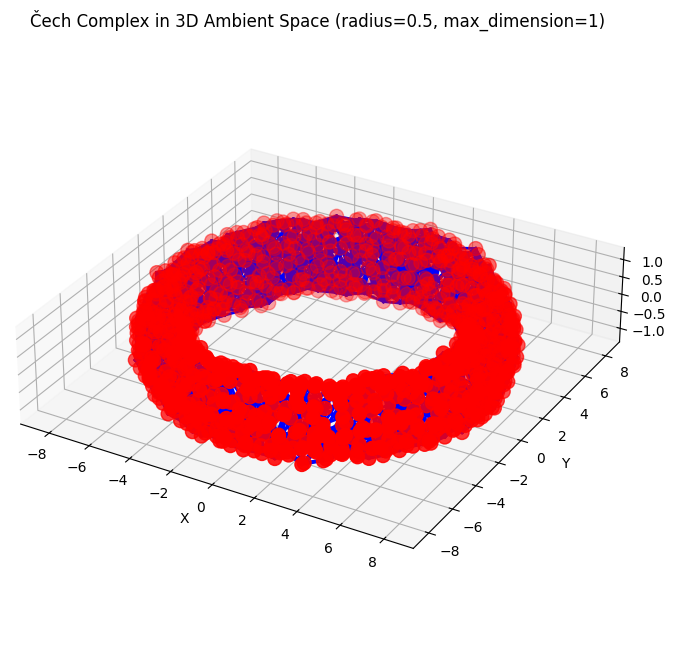

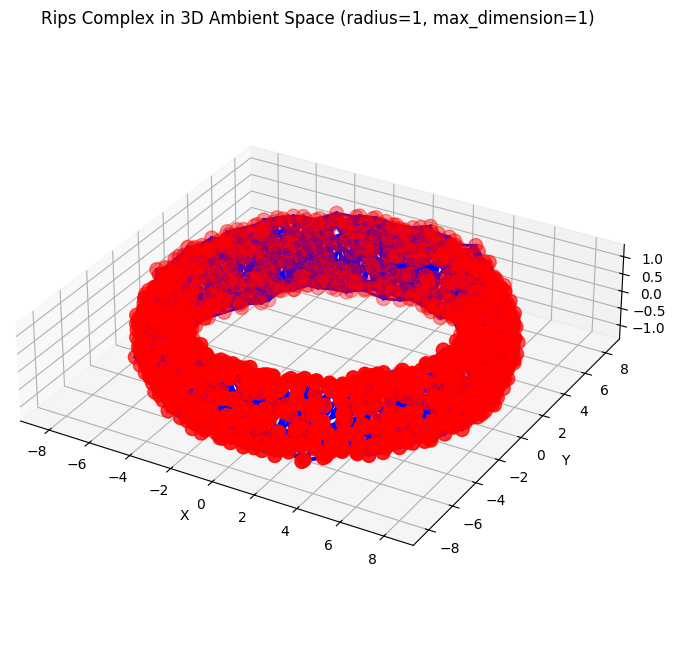

In [4]:
# Example usage with a 2D point cloud:
radius_cech = .5
radius_rips = 1
complex_2d = CechAndRipsComplex(point_cloud,1)
# Plot the Čech complex in 2D
complex_2d.plot_complex_2d(radius_cech, 'cech', [4,4,1])
# Plot the Rips complex in 2D
complex_2d.plot_complex_2d(radius_rips, 'rips', [4,4,1])

In [5]:
# Example usage with a 3D point cloud:
# complex_3d = CechAndRipsComplex(point_cloud)
# # Plot the Čech complex in 3D
# complex_3d.plot_complex_3d(radius_cech, 'cech', [4,4,1])
# # Plot the Rips complex in 3D
# complex_3d.plot_complex_3d(radius_rips, 'rips', [4,4,1])
# # Plot the Rips complex in 3D with interactive controls
# complex_3d.plot_complex_3d_interactive(radius_rips, 'rips',aspect_ratio={'x':4, 'y':4, 'z':1})

### Torus Complex

The above code of obtaining the interactive plot of the torus complex can take several minutes to run. Here is a Screenshot of the Torus Complex:

![Torus complex](https://github.com/iumery/topological-data-analysis-with-python/blob/main/Torus%20Complex.png?raw=true)

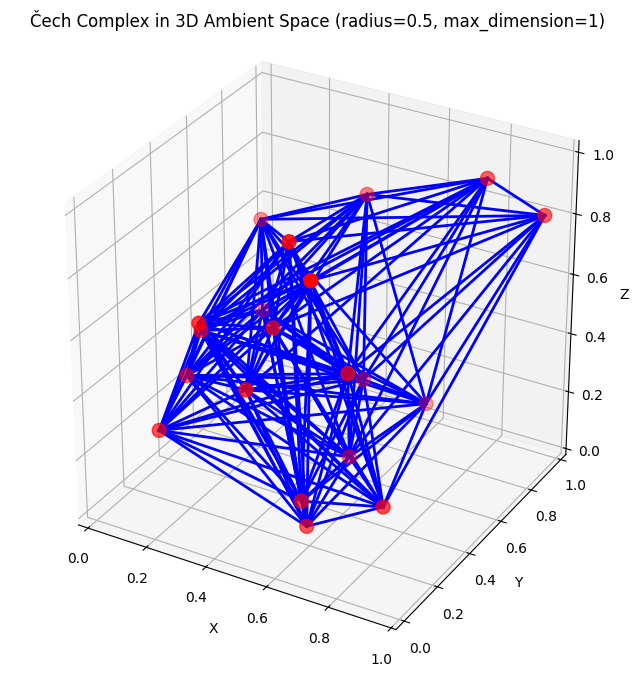

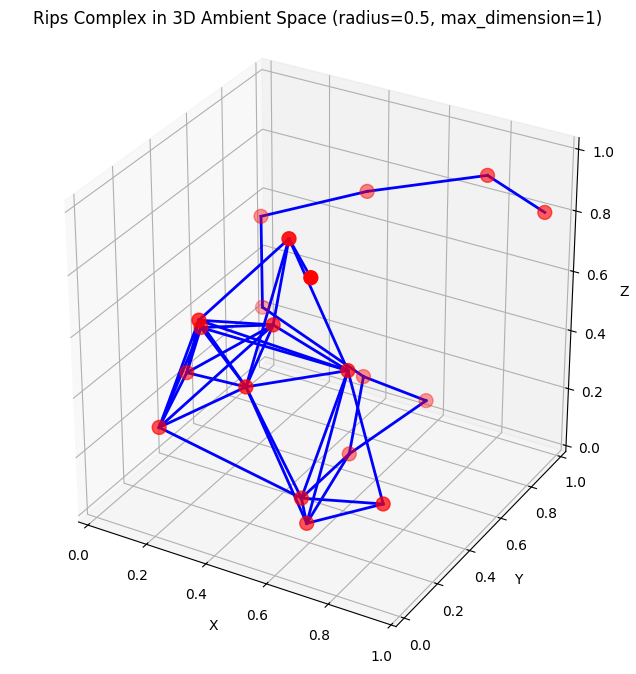

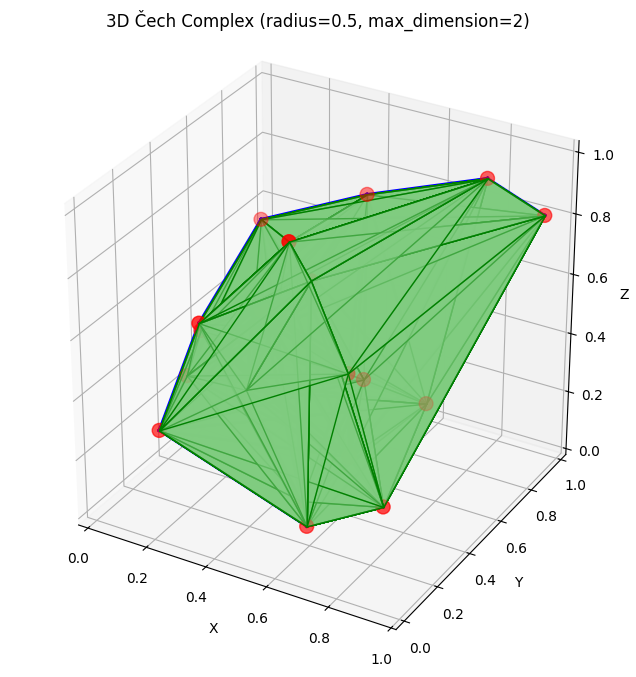

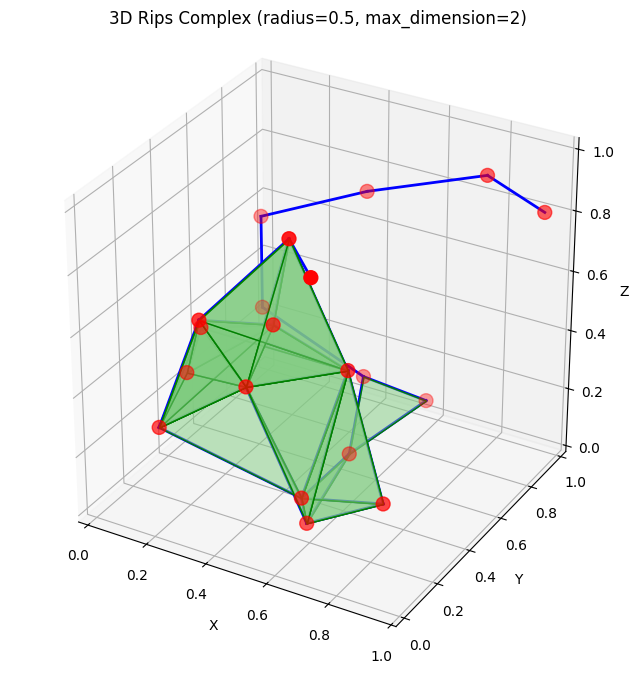

In [6]:
np.random.seed(42)
point_cloud_3d = [tuple(point) for point in np.random.rand(20, 3)]
radius = 0.5
complex_2d = CechAndRipsComplex(point_cloud_3d,1)
# Plot the Čech complex in 2D
complex_2d.plot_complex_2d(radius, 'cech')
# Plot the Rips complex in 2D
complex_2d.plot_complex_2d(radius, 'rips')

# Example usage with a 3D point cloud:
complex_3d = CechAndRipsComplex(point_cloud_3d)
# Plot the Čech complex in 3D
complex_3d.plot_complex_3d(radius, 'cech')
# Plot the Rips complex in 3D
complex_3d.plot_complex_3d(radius, 'rips')
# Example usage with a 3D point cloud and interactive visualization, the plot will be opened in a web browser
complex_3d.plot_complex_3d_interactive(radius, 'rips')

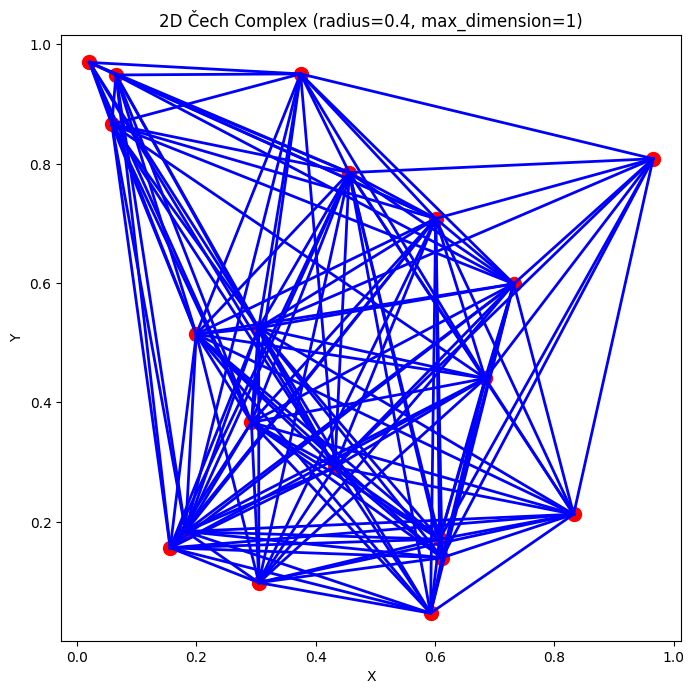

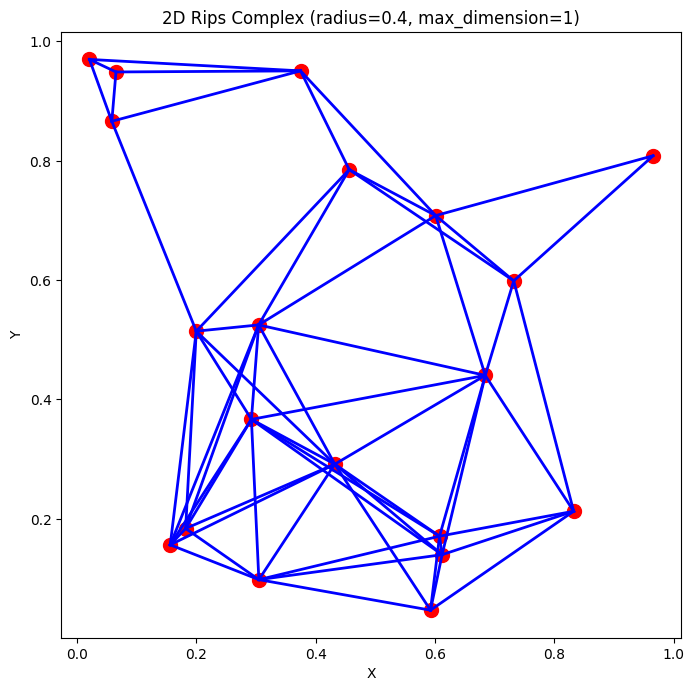

In [7]:
np.random.seed(42)
point_cloud_2d = [tuple(point) for point in np.random.rand(20, 2)]
radius = 0.4
complex_2d = CechAndRipsComplex(point_cloud_2d)
# Plot the Čech complex in 2D
complex_2d.plot_complex_2d(radius, 'cech')
# Plot the Rips complex in 2D
complex_2d.plot_complex_2d(radius, 'rips')